# PPI analysis using ARMA

In [1]:
import pandas as pd
import numpy as np
import os
from nltools.data import Brain_Data, Design_Matrix
from nltools.file_reader import onsets_to_dm
import nibabel as nib
import glob
import nilearn
import matplotlib.pyplot as plt
import seaborn as sns

from nltools.stats import zscore, fdr, one_sample_permutation
from scipy.stats import binom, ttest_1samp

from scipy import stats

/gpfs/ysm/project/joormann/oad4/conda_envs/naturalistic/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
# get relevant subjects first
df = pd.read_csv('../scr_amg_hipp_all.csv')
subject_list = df['sub'].unique()
subject_list

array(['sub-189', 'sub-205', 'sub-071', 'sub-204', 'sub-085', 'sub-100',
       'sub-132', 'sub-185', 'sub-167', 'sub-043', 'sub-062', 'sub-073',
       'sub-082', 'sub-030', 'sub-160', 'sub-196', 'sub-1223', 'sub-169',
       'sub-1222', 'sub-055', 'sub-170', 'sub-047', 'sub-177', 'sub-130',
       'sub-172', 'sub-200', 'sub-173', 'sub-026', 'sub-059', 'sub-072',
       'sub-1232', 'sub-166', 'sub-032', 'sub-016', 'sub-1205', 'sub-186',
       'sub-056', 'sub-053', 'sub-150', 'sub-065', 'sub-154', 'sub-193',
       'sub-165', 'sub-103', 'sub-168', 'sub-102', 'sub-048', 'sub-027',
       'sub-182', 'sub-202', 'sub-203', 'sub-066', 'sub-038', 'sub-184',
       'sub-171', 'sub-179', 'sub-153', 'sub-144', 'sub-178', 'sub-063',
       'sub-010', 'sub-158', 'sub-083', 'sub-126', 'sub-152'],
      dtype=object)

In [3]:
# load timeseries (to grab amygdala ts)
sub_arr = np.load('../sub_55.npy', allow_pickle=True)
ts_arr = np.load('../array_55.npy', allow_pickle=True)

CSplusUS1', 'CSminus1', 'CSplus1', 'CSminusUS2', 'CSplus2','CSminus2'

In [5]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [7]:
func_file = '/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/{sub}_ses-1_denoise_smooth6mm_task-RV_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
events_file = '/gpfs/gibbs/pi/levy_ifat/Or/RV_FSL/eventfiles/{sub}.csv'
# # run group analysis
for sub in subject_list:
    print(f'Running {sub}')
    # grab functional files
    func = func_file.format(sub=sub)
    event = events_file.format(sub=sub)
    
    # grab amygdala timeseries
    idx = np.where(sub_arr==sub)[0][0]
    # grab that subjects amygdala ts
    amg = ts_arr[idx][:,20] # ROI 20 in DiFuMo is the amygdala
    # load data to compare later
    smoothed = Brain_Data(func)
    tr=2
    n_tr = nib.load(func).shape[-1]
    onsets = pd.read_csv(event, sep=',')
    onsets.columns = ['Stim', 'Onset', 'Duration']
    dm = onsets_to_dm(onsets, sampling_freq=1/tr, run_length=n_tr)
    us_variables = ['CSplusUS1', 'CSminusUS2']
    csminus_vars = [ 'CSminus1', 'CSminus2']
    csplus_vars = ['CSplus1', 'CSplus2']
    ppi_dm = dm.drop(us_variables, axis=1)
    ppi_dm['US'] = pd.Series(dm.loc[:, us_variables].sum(axis=1))
    ppi_dm['CSm'] = pd.Series(dm.loc[:, csminus_vars].sum(axis=1))
    ppi_dm['CSp'] = pd.Series(dm.loc[:, csplus_vars].sum(axis=1))
    
    ppi_dm_conv = ppi_dm.convolve()
    ppi_dm_conv['amg'] = amg
    ppi_dm_conv['amg_US'] = ppi_dm_conv['amg']*ppi_dm_conv['US_c0']
    ppi_dm_conv['amg_CSm'] = ppi_dm_conv['amg']*ppi_dm_conv['CSm_c0']
    ppi_dm_conv['amg_CSp'] = ppi_dm_conv['amg']*ppi_dm_conv['CSp_c0']
    
    dm = Design_Matrix(pd.concat([ppi_dm_conv], axis=1), sampling_freq=1/tr)
    smoothed.X = dm
    ppi_stats = smoothed.regress(mode='ols')
    ppi_stats['beta'].write(f'/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/ppi/arma/{sub}_betas_ppi_arma.nii.gz')
    ppi_stats['beta'][int(np.where(smoothed.X.columns=='amg_US')[0][0])].write(f'/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/ppi/arma/{sub}_amg_US_contrast_ppi_arma.nii.gz')
    ppi_stats['beta'][int(np.where(smoothed.X.columns=='amg_CSm')[0][0])].write(f'/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/ppi/arma/{sub}_amg_CSm_contrast_ppi_arma.nii.gz')
    ppi_stats['beta'][int(np.where(smoothed.X.columns=='amg_CSp')[0][0])].write(f'/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/ppi/arma/{sub}_amg_CSp_contrast_ppi_arma.nii.gz')
    

Running sub-189


/gpfs/ysm/project/joormann/oad4/conda_envs/naturalistic/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/gpfs/ysm/project/joormann/oad4/conda_envs/naturalistic/lib/python3.7/site-packages/statsmodels/base/model.py:548: Hessia

LinAlgError: SVD did not converge

/gpfs/ysm/project/joormann/oad4/conda_envs/naturalistic/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/gpfs/ysm/project/joormann/oad4/conda_envs/naturalistic/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/gpfs/ysm/project/joormann/oad4/conda_envs/naturalistic/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/gpfs/ysm/project/joormann/oad4/conda_envs/naturalistic/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/gpfs/ysm/project/joormann/oad4/conda_envs/naturalistic/lib/py

In [9]:
#con1_name = 'horizontal_checkerboard'
con1_file_list = glob.glob(os.path.join('/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/ppi/arma/sub-*_amg_US_contrast_ppi_arma.nii.gz'))
con2_file_list = glob.glob(os.path.join('/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/ppi/arma/sub-*_amg_CSm_contrast_ppi_arma.nii.gz'))
con3_file_list = glob.glob(os.path.join('/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/ppi/arma/sub-*_amg_CSp_contrast_ppi_arma.nii.gz'))
con1_file_list.sort()
#print(con1_file_list)
con1_dat = Brain_Data(con1_file_list)
con1_stats = con1_dat.ttest()
#con1_stats['t'].iplot()

In [10]:
con2_dat = Brain_Data(con2_file_list)
con2_stats = con2_dat.ttest()
con3_dat = Brain_Data(con3_file_list)
con3_stats = con3_dat.ttest()

In [21]:
# compare two
# comparing US vs minus
con_datUvM = con1_dat - con2_dat
con_datUvM_stat =  con_datUvM.ttest(threshold_dict={'fdr':.05})
con_datUvM_stat['thr_t'].iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

In [12]:
con1_stats = con2_dat.ttest(threshold_dict={'fdr':.05})
con1_stats['thr_t'].iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

## Posterior hippocampus

In [11]:
# grab difumo atlas
a = nilearn.datasets.fetch_atlas_difumo(dimension=256)
mask = Brain_Data(a.maps)
# binarize the mask
mask_bin = mask.threshold(upper=.0001, binarize=True)

/gpfs/ysm/project/joormann/oad4/conda_envs/naturalistic/lib/python3.7/site-packages/numpy/lib/npyio.py:2407: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


Ttest_1sampResult(statistic=3.377889405584922, pvalue=0.0012471417350502717)

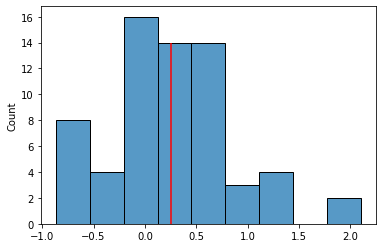

In [13]:
# grab posterior hippocampus (ROI 94)
%matplotlib inline
postHipp = con1_dat.extract_roi(mask=mask_bin[94])
postHippm = con2_dat.extract_roi(mask=mask_bin[94])
postHippp = con3_dat.extract_roi(mask=mask_bin[94])

sns.histplot(postHipp)
plt.vlines(x=np.mean(postHipp), ymin=0, ymax=14, color='red')
stats.ttest_1samp(postHipp, 0)

In [34]:
stats.ttest_rel(postHipp, postHippm)

Ttest_relResult(statistic=3.135808503053105, pvalue=0.0025884752220224744)

In [15]:
stats.ttest_1samp(postHippp, 0)

Ttest_1sampResult(statistic=-1.6640237641766773, pvalue=0.1009970007702753)

Ttest_1sampResult(statistic=-2.3695221928172026, pvalue=0.020838058453096008)

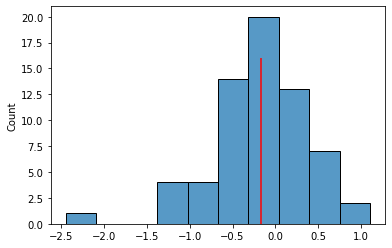

In [16]:
# test vmpfc
vmpfc = con1_dat.extract_roi(mask=mask_bin[42])
vmpfcm = con2_dat.extract_roi(mask=mask_bin[42])
vmpfcp = con3_dat.extract_roi(mask=mask_bin[42])
sns.histplot(vmpfc)
plt.vlines(x=np.mean(vmpfc), ymin=0, ymax=16, color='red')
stats.ttest_1samp(vmpfc, 0)

In [18]:
stats.ttest_1samp(vmpfcp, 0)

Ttest_1sampResult(statistic=-0.20707150536377522, pvalue=0.8366114481670741)

In [25]:
stats.ttest_rel(vmpfc, vmpfcm)

Ttest_relResult(statistic=-0.30812316365758347, pvalue=0.758989237094208)

Ttest_1sampResult(statistic=1.383373425721822, pvalue=0.1713571226091239)

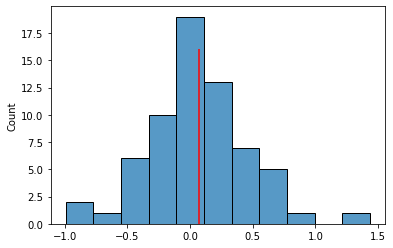

In [26]:
# anterior hippocampus
antHipp = con1_dat.extract_roi(mask=mask_bin[167])
antHippm = con2_dat.extract_roi(mask=mask_bin[167])
antHippp = con3_dat.extract_roi(mask=mask_bin[167])
sns.histplot(antHipp)
plt.vlines(x=np.mean(antHipp), ymin=0, ymax=16, color='red')
stats.ttest_1samp(antHipp, 0)

In [28]:
stats.ttest_rel(antHipp, antHippm)

Ttest_relResult(statistic=2.7705550559434404, pvalue=0.007316554128673572)

Ttest_1sampResult(statistic=-1.0028096212423763, pvalue=0.31972925023071413)

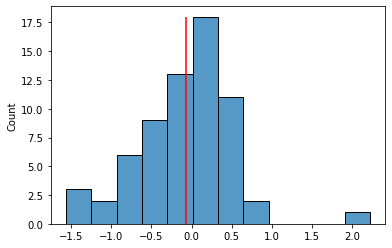

In [29]:
# control region (supramarginal left)
supra = con1_dat.extract_roi(mask=mask_bin[21])
supram = con2_dat.extract_roi(mask=mask_bin[21])
suprap = con3_dat.extract_roi(mask=mask_bin[21])
sns.histplot(supra)
plt.vlines(x=np.mean(supra), ymin=0, ymax=18, color='red')
stats.ttest_1samp(supra, 0)

In [31]:
stats.ttest_rel(supra, suprap)

Ttest_relResult(statistic=-0.6899416164710032, pvalue=0.4927252301943944)

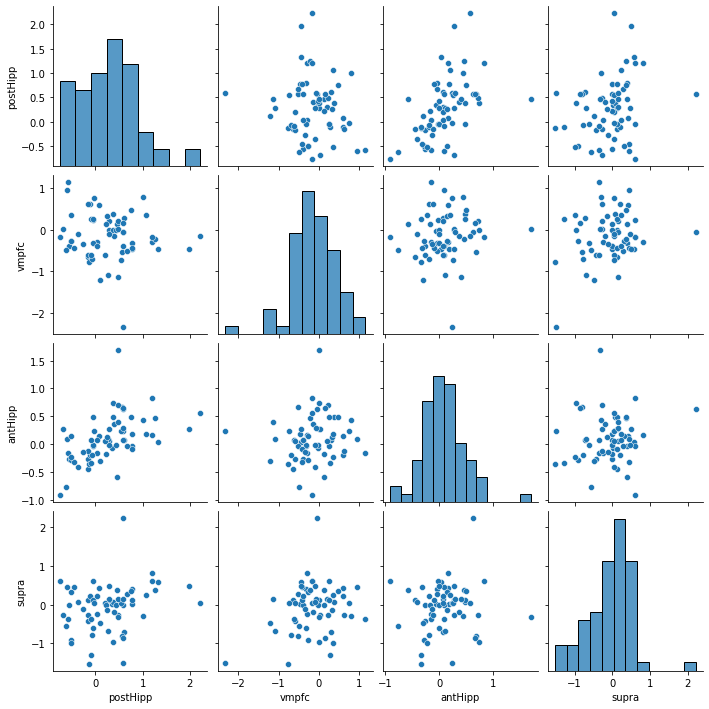

In [21]:
# combine all to dataset
d = pd.DataFrame({'postHipp': postHipp, 'vmpfc':vmpfc, 'antHipp':antHipp, 'supra':supra})
sns.pairplot(d)

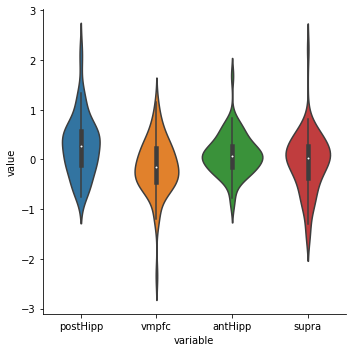

In [23]:
sns.catplot(x='variable', y='value', data=d.melt(), kind='violin')
#plt.savefig('ppi_results.png')

Ttest_1sampResult(statistic=3.1358085030531027, pvalue=0.002588475222022498)

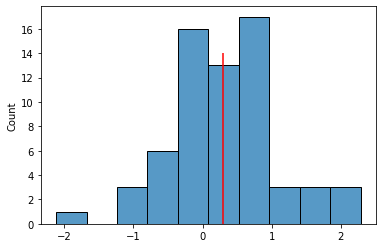

In [33]:
con_datUvM
postHippComp = con_datUvM.extract_roi(mask=mask_bin[94])
#postHippm = con2_dat.extract_roi(mask=mask_bin[94])
#postHippp = con3_dat.extract_roi(mask=mask_bin[94])

sns.histplot(postHippComp)
plt.vlines(x=np.mean(postHippComp), ymin=0, ymax=14, color='red')
stats.ttest_1samp(postHippComp, 0)